# Modeling

In [1]:
import pandas as pd
import numpy as np
from glob import glob
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
# Step 1: Load all feature CSVs

file_paths = sorted(glob("/Users/sarvesh/Desktop/stress-detection-wesad/data/features/S*_features.csv")) 
subject_ids = [f.split("/")[-1].split("_")[0] for f in file_paths]

In [3]:
# Step 2: Track metrics
accuracies = []
f1s = []
per_subject_reports = {}

In [4]:
# Step 3: LOSO loop
for i, test_subj in enumerate(subject_ids):
    print(f"\n🔄 Testing on {test_subj} (LOSO fold {i+1}/{len(subject_ids)})")

    test_df = pd.read_csv(file_paths[i])
    train_dfs = [pd.read_csv(f) for j, f in enumerate(file_paths) if j != i]
    train_df = pd.concat(train_dfs, ignore_index=True)

    # ✅ Filter only labels 1, 2, 3 and shift to 0-indexed for classifier
    valid_labels = [1, 2, 3]
    train_df = train_df[train_df['label'].isin(valid_labels)]
    test_df = test_df[test_df['label'].isin(valid_labels)]

    # Shift labels: 1→0, 2→1, 3→2
    train_df['label'] = train_df['label'] - 1
    test_df['label'] = test_df['label'] - 1

    X_train, y_train = train_df.drop(columns=['label']), train_df['label']
    X_test, y_test = test_df.drop(columns=['label']), test_df['label']

    # Step 4: Train model
    model = RandomForestClassifier(n_estimators=30, random_state=42)
    model.fit(X_train, y_train)

    # Step 5: Evaluate
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Map labels back to 1–3 for reporting
    y_pred_orig = y_pred + 1
    y_test_orig = y_test + 1

    class_names = ['Baseline (1)', 'Stress (2)', 'Amusement (3)']
    # print(classification_report(y_test_orig, y_pred_orig, target_names=class_names))

    accuracies.append(acc)
    f1s.append(f1)
    per_subject_reports[test_subj] = classification_report(y_test_orig, y_pred_orig, output_dict=True)

    print(f"✅ Accuracy: {acc:.4f} | F1 (weighted): {f1:.4f}")




🔄 Testing on S10 (LOSO fold 1/15)
✅ Accuracy: 0.8800 | F1 (weighted): 0.8502

🔄 Testing on S11 (LOSO fold 2/15)
✅ Accuracy: 0.8553 | F1 (weighted): 0.8431

🔄 Testing on S13 (LOSO fold 3/15)
✅ Accuracy: 0.9733 | F1 (weighted): 0.9728

🔄 Testing on S14 (LOSO fold 4/15)
✅ Accuracy: 0.8000 | F1 (weighted): 0.7496

🔄 Testing on S15 (LOSO fold 5/15)
✅ Accuracy: 0.8667 | F1 (weighted): 0.8646

🔄 Testing on S16 (LOSO fold 6/15)
✅ Accuracy: 0.9178 | F1 (weighted): 0.9090

🔄 Testing on S17 (LOSO fold 7/15)
✅ Accuracy: 0.9333 | F1 (weighted): 0.9297

🔄 Testing on S2 (LOSO fold 8/15)
✅ Accuracy: 0.5634 | F1 (weighted): 0.5403

🔄 Testing on S3 (LOSO fold 9/15)
✅ Accuracy: 0.5890 | F1 (weighted): 0.5795

🔄 Testing on S4 (LOSO fold 10/15)
✅ Accuracy: 0.8611 | F1 (weighted): 0.8405

🔄 Testing on S5 (LOSO fold 11/15)
✅ Accuracy: 0.7808 | F1 (weighted): 0.7679

🔄 Testing on S6 (LOSO fold 12/15)
✅ Accuracy: 0.8356 | F1 (weighted): 0.7644

🔄 Testing on S7 (LOSO fold 13/15)
✅ Accuracy: 0.6438 | F1 (weight

In [5]:
# Step 6: Summary
print("\n📊 LOSO Summary:")
print(f"Mean Accuracy: {np.mean(accuracies):.4f}")
print(f"Mean F1 Score: {np.mean(f1s):.4f}")


📊 LOSO Summary:
Mean Accuracy: 0.8087
Mean F1 Score: 0.7873


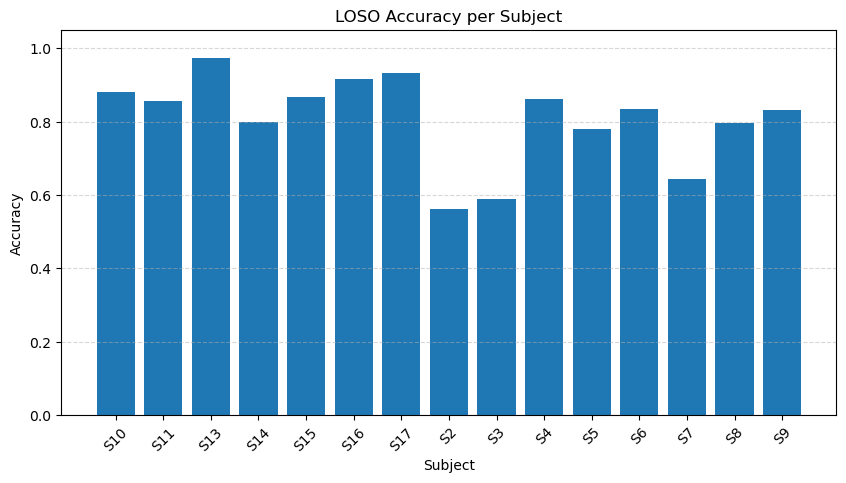

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.bar(subject_ids, accuracies)
plt.title("LOSO Accuracy per Subject")
plt.ylabel("Accuracy")
plt.xlabel("Subject")
plt.xticks(rotation=45)
plt.ylim(0, 1.05)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()


In [10]:
importances = model.feature_importances_  # only for tree-based models
pd.Series(importances, index=X_train.columns).sort_values(ascending=False).head(10)


eda_mean               0.315536
eda_peak_count         0.174046
resp_std               0.127782
eda_std                0.079909
mean_rr                0.067791
eda_slope              0.057420
resp_zero_crossings    0.052657
rmssd                  0.042512
sdnn                   0.030697
ecg_peak_count         0.028548
dtype: float64

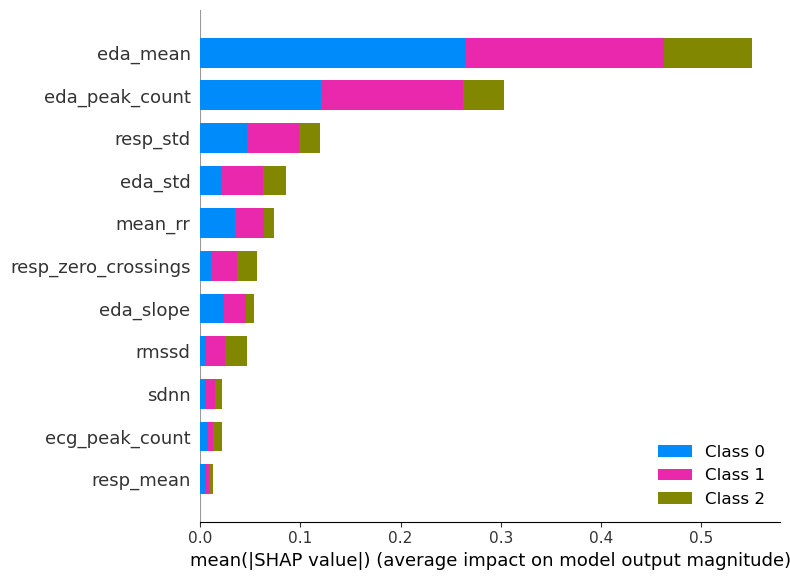

In [7]:
import shap

# Create explainer and sample a few rows
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

# Summary plot for all classes
shap.summary_plot(shap_values, features=X_test, feature_names=X_test.columns)

In [11]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
import pandas as pd
import numpy as np
from glob import glob
import os


In [12]:

# Step 1: Load all CSVs
file_paths = sorted(glob("/Users/sarvesh/Desktop/wesad/data/features/S*_features.csv")) 
subject_ids = [f.split("/")[-1].split("_")[0] for f in file_paths]

# Step 2: Track metrics
accuracies = []
f1s = []
per_subject_reports = {}

# Step 3: LOSO Loop
for i, test_subj in enumerate(subject_ids):
    print(f"\n🔄 Testing on {test_subj} (LOSO fold {i+1}/{len(subject_ids)})")

    # Load test and train data
    test_df = pd.read_csv(file_paths[i])
    train_dfs = [pd.read_csv(f) for j, f in enumerate(file_paths) if j != i]
    train_df = pd.concat(train_dfs, ignore_index=True)

    # Filter to valid classes (e.g., 0: baseline, 1: stress, 2: amusement, 3: meditation)    offset by 1 as XGBoost expects [0,1,2,3]
    valid_classes = [0, 1, 2, 3]
    train_df = train_df[train_df['label'].isin(valid_classes)]
    test_df = test_df[test_df['label'].isin(valid_classes)]

    # Prepare features and labels
    X_train, y_train = train_df.drop(columns=['label']), train_df['label']
    X_test, y_test = test_df.drop(columns=['label']), test_df['label']

    # Step 4: Train XGBoost model
    model = XGBClassifier(objective='multi:softprob', num_class=4, eval_metric='mlogloss', use_label_encoder=False)
    model.fit(X_train, y_train)

    # Step 5: Evaluate
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    accuracies.append(acc)
    f1s.append(f1)
    per_subject_reports[test_subj] = classification_report(y_test, y_pred, output_dict=True)

    print(f"✅ Accuracy: {acc:.4f} | F1 (weighted): {f1:.4f}")



🔄 Testing on S10 (LOSO fold 1/15)
✅ Accuracy: 0.7718 | F1 (weighted): 0.7427

🔄 Testing on S11 (LOSO fold 2/15)
✅ Accuracy: 0.6503 | F1 (weighted): 0.6573

🔄 Testing on S13 (LOSO fold 3/15)
✅ Accuracy: 0.7237 | F1 (weighted): 0.6835

🔄 Testing on S14 (LOSO fold 4/15)
✅ Accuracy: 0.5960 | F1 (weighted): 0.5413

🔄 Testing on S15 (LOSO fold 5/15)
✅ Accuracy: 0.6713 | F1 (weighted): 0.6071

🔄 Testing on S16 (LOSO fold 6/15)
✅ Accuracy: 0.7338 | F1 (weighted): 0.7195

🔄 Testing on S17 (LOSO fold 7/15)
✅ Accuracy: 0.6506 | F1 (weighted): 0.6528

🔄 Testing on S2 (LOSO fold 8/15)
✅ Accuracy: 0.5698 | F1 (weighted): 0.4756

🔄 Testing on S3 (LOSO fold 9/15)
✅ Accuracy: 0.7198 | F1 (weighted): 0.6878

🔄 Testing on S4 (LOSO fold 10/15)
✅ Accuracy: 0.4944 | F1 (weighted): 0.4619

🔄 Testing on S5 (LOSO fold 11/15)
✅ Accuracy: 0.6818 | F1 (weighted): 0.6556

🔄 Testing on S6 (LOSO fold 12/15)
✅ Accuracy: 0.7304 | F1 (weighted): 0.6990

🔄 Testing on S7 (LOSO fold 13/15)
✅ Accuracy: 0.4965 | F1 (weight

In [13]:
print("\n📈 LOSO XGBoost Multiclass Summary:")
print(f"Average Accuracy: {np.mean(accuracies):.4f}")
print(f"Average F1 Score:  {np.mean(f1s):.4f}")



📈 LOSO XGBoost Multiclass Summary:
Average Accuracy: 0.6423
Average F1 Score:  0.6066


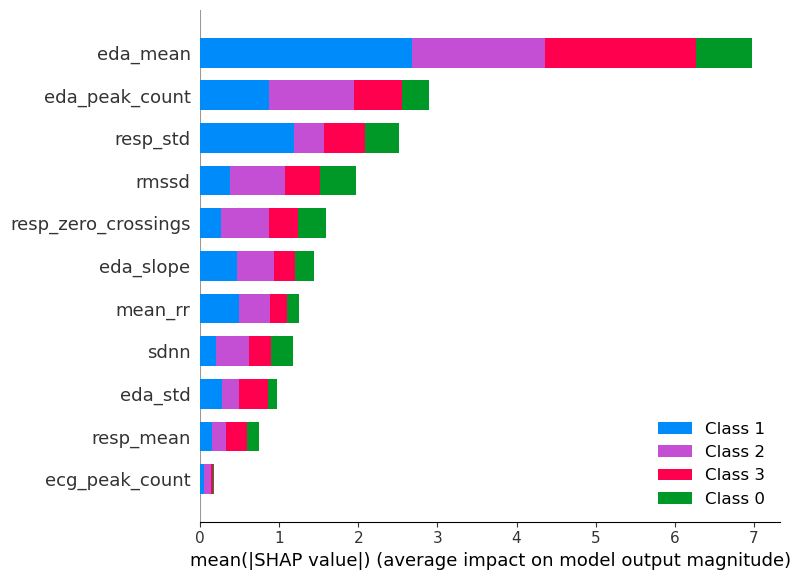

In [14]:
# Create explainer and sample a few rows
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

# Summary plot for all classes
shap.summary_plot(shap_values, features=X_test, feature_names=X_test.columns)

In [15]:
y_pred_orig = y_pred + 1
y_test_orig = y_test + 1


In [16]:
from sklearn.metrics import classification_report

class_names = ['Baseline (1)', 'Stress (2)', 'Amusement (3)', 'Meditation (4)']
print(classification_report(y_test_orig, y_pred_orig, target_names=class_names))


                precision    recall  f1-score   support

  Baseline (1)       0.76      0.78      0.77        68
    Stress (2)       0.88      0.95      0.91        39
 Amusement (3)       0.57      0.76      0.65        21
Meditation (4)       0.00      0.00      0.00        12

      accuracy                           0.76       140
     macro avg       0.55      0.62      0.58       140
  weighted avg       0.70      0.76      0.73       140



/Users/sarvesh/anaconda3/envs/datasci/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sarvesh/anaconda3/envs/datasci/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sarvesh/anaconda3/envs/datasci/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

In [3]:
import shap

# Create explainer and sample a few rows
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

# Summary plot for all classes
shap.summary_plot(shap_values, features=X_test, feature_names=X_test.columns)


NameError: name 'model' is not defined